### Example to interpolate ACCESS-ESM1.5 ocean restart to ACCESS-OM2
The ESM1.5 and OM2 ocean components both use MOM5, however they are not on the same vertical grid. 
To use ESM restarts in the OM2 model, we interpolate the ocean_temp_salt.res.nc from the relevant ESM restart to the OM vertical grid.
Only the temperature and salt file is interpolated and use in the OM2 run - velocities etc begin from zero, a 'cold start'.

In [13]:
import matplotlib.pyplot as plt

In [5]:
import xarray as xr
import numpy as np

In [105]:
from distributed import Client

client = Client(threads_per_worker=1)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40531 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40531/status,
Dashboard: /proxy/40531/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38837,Workers: 2
Dashboard: /proxy/40531/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:40557,Total threads: 1
Dashboard: /proxy/34775/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:40653,


In [7]:
# import esm cell depths/thicknesses/edge depths
thkcello_esm = xr.open_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Ofx/volcello/gn/latest/volcello_Ofx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc')
lev_edges = np.unique(np.concatenate(thkcello_esm.lev_bnds.values))
lev_edges.size

51

In [19]:
lev_edges_ds = xr.DataArray(lev_edges, coords = {'lev_edges':lev_edges})

In [8]:
# import om2 cell depths/thicknesses/edge depths
om2_thickness = xr.open_mfdataset('/g/data/ik11/outputs/access-om2/1deg_jra55_ryf9091_gadi/output000/ocean/ocean.nc', combine = 'by_coords')

Modify path and time here to get restart file needed

In [9]:
cd /g/data/p73/archive/CMIP6/ACCESS-ESM1-5/SSP-585-10-re1/restart/ocn

/g/data/p73/archive/CMIP6/ACCESS-ESM1-5/SSP-585-10-re1/restart/ocn


In [10]:
restart_dir = '/g/data/p73/archive/CMIP6/ACCESS-ESM1-5/SSP-585-10-re1/restart/ocn/'

In [11]:
ocean_file  = xr.open_mfdataset(restart_dir + 'ocean_temp_salt.res.nc-20141231')
ocean_file

<xarray.Dataset> Size: 86MB
Dimensions:  (xaxis_1: 360, yaxis_1: 300, zaxis_1: 50, Time: 1)
Coordinates:
  * xaxis_1  (xaxis_1) float64 3kB 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
  * yaxis_1  (yaxis_1) float64 2kB 1.0 2.0 3.0 4.0 ... 297.0 298.0 299.0 300.0
  * zaxis_1  (zaxis_1) float64 400B 1.0 2.0 3.0 4.0 5.0 ... 47.0 48.0 49.0 50.0
  * Time     (Time) float64 8B 1.0
Data variables:
    temp     (Time, zaxis_1, yaxis_1, xaxis_1) float64 43MB dask.array<chunksize=(1, 50, 300, 360), meta=np.ndarray>
    salt     (Time, zaxis_1, yaxis_1, xaxis_1) float64 43MB dask.array<chunksize=(1, 50, 300, 360), meta=np.ndarray>
Attributes:
    filename:  RESTART/ocean_temp_salt.res.nc

In [14]:
# fill in dir where the interpolated restart files should go
interp_dir = '/g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/'

In [15]:
def vert_interp_bottom_save_salt(restart_dir,file_name, interp_dir, new_file_name):
    ocean_file  = xr.open_mfdataset(restart_dir + file_name)
    print('open ' + str(file_name))
    
    if 'zaxis_1' in ocean_file.coords:
        print('need to intepolate')
        name_list = [name for name in ocean_file.data_vars]
        print(name_list)
        
        #make coordinates in z the same as esm_levels
        ocean_file_zcoord = ocean_file.rename({'zaxis_1':'lev'}).assign_coords({'lev' : thkcello_esm.lev})
    
        var_master = []
        for nn in ['salt']:
            if 'lev' in ocean_file_zcoord[nn].isel(Time = 0).coords:
                print(nn)
    
                ## do itnerpolation for each grid point
                var_interp = xr.apply_ufunc(
                    custom_interp_with_zero_check,
                    ocean_file_zcoord[nn],                  # 3D data to interpolate (lev, j, i) over time
                    thkcello_esm.lev,        # source lev grid (1D array)
                    om2_thickness.st_ocean,  # target vertical grid (1D array)
                    input_core_dims=[ ["lev"], ["lev"],["st_ocean"]],
                    output_core_dims=[["st_ocean"]],
                    vectorize=True,
                    dask="parallelized",  # if using dask-backed DataArrays
                    output_dtypes=[ocean_file[nn].dtype],
                )
                var_master.append(var_interp.rename(nn))
                print(var_master)
            else:
                var_master.append(ocean_file_zcoord[nn].rename(nn))

        for nn in ['temp']:
            if 'lev' in ocean_file_zcoord[nn].isel(Time = 0).coords:
                print(nn)
    
                ## do itnerpolation for each grid point
                var_interp = xr.apply_ufunc(
                    interp_lev_gridpoint_copy,
                    ocean_file_zcoord[nn],                  # 3D data to interpolate (lev, j, i) over time
                    thkcello_esm.lev,        # source lev grid (1D array)
                    om2_thickness.st_ocean,  # target vertical grid (1D array)
                    input_core_dims=[ ["lev"], ["lev"],["st_ocean"]],
                    output_core_dims=[["st_ocean"]],
                    vectorize=True,
                    dask="parallelized",  # if using dask-backed DataArrays
                    output_dtypes=[ocean_file[nn].dtype],
                )
                var_master.append(var_interp.rename(nn))
                print(var_master)
            else:
                var_master.append(ocean_file_zcoord[nn].rename(nn))
        
        dataset = xr.merge(var_master)
        dataset = dataset.rename({'st_ocean':'zaxis_1'}).assign_coords({'zaxis_1':ocean_file.zaxis_1})
        dataset = dataset.transpose('Time','zaxis_1','yaxis_1','xaxis_1')
    
        dataset.to_netcdf(interp_dir + new_file_name)
        print(interp_dir + new_file_name)
    else:
        print('no zaxis')
        
    return 

In [16]:
def interp_lev_gridpoint_copy(theta_lev, esm_lev, om_lev): #thkcello_esm.lev.values
    # interpolate quantity theta linearly into om grid levels from esm
    theta_interp = np.interp(om_lev,  esm_lev, theta_lev)
    
    return theta_interp #interp(om_lev)

In [17]:
def custom_interp_with_zero_check( theta_lev,  esm_lev,om_lev):
    """
    Interpolate theta_lev from esm_lev to om_lev, but if the value in the next esm grid cell is 0,
    then use the previous value instead of interpolating.

    Parameters
    ----------
    om_lev : 1D array
        Output depth levels (target grid)
    esm_lev : 1D array
        Input depth levels (source grid)
    theta_lev : 1D array
        Values at esm_lev

    Returns
    -------
    theta_interp : 1D array
        Interpolated values at om_lev
    """
    theta_interp = np.empty_like(om_lev)
    for i, z in enumerate(om_lev):
        # Find where z would be inserted in esm_lev
        if z <= esm_lev[0]:
            theta_interp[i] = theta_lev[0]
        elif z >= esm_lev[-1]:
            theta_interp[i] = theta_lev[-1]
        else:
            idx = np.searchsorted(esm_lev, z) - 1
            x0, x1 = esm_lev[idx], esm_lev[idx+1]
            y0, y1 = theta_lev[idx], theta_lev[idx+1]

            if y1 == 0:
                theta_interp[i] = y0  # Duplicate previous value
            else:
                # Linear interpolation
                theta_interp[i] = y0 + (y1 - y0) * (z - x0) / (x1 - x0)
    return theta_interp


In [18]:
restart_dir

'/g/data/p73/archive/CMIP6/ACCESS-ESM1-5/SSP-585-10-re1/restart/ocn/'

In [19]:
interp_dir

'/g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/'

In [20]:
vert_interp_bottom_save_salt(restart_dir,'ocean_temp_salt.res.nc-20141231',\
                        interp_dir, 'ocean_temp_salt_bottominterp_salttest.nc')

open ocean_temp_salt.res.nc-20141231
need to intepolate
['temp', 'salt']
salt
[<xarray.DataArray 'salt' (Time: 1, yaxis_1: 300, xaxis_1: 360, st_ocean: 50)> Size: 43MB
dask.array<transpose, shape=(1, 300, 360, 50), dtype=float64, chunksize=(1, 300, 360, 50), chunktype=numpy.ndarray>
Coordinates:
  * xaxis_1   (xaxis_1) float64 3kB 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
  * yaxis_1   (yaxis_1) float64 2kB 1.0 2.0 3.0 4.0 ... 297.0 298.0 299.0 300.0
  * Time      (Time) float64 8B 1.0
  * st_ocean  (st_ocean) float64 400B 1.152 3.649 6.565 ... 5.034e+03 5.254e+03]
temp
[<xarray.DataArray 'salt' (Time: 1, yaxis_1: 300, xaxis_1: 360, st_ocean: 50)> Size: 43MB
dask.array<transpose, shape=(1, 300, 360, 50), dtype=float64, chunksize=(1, 300, 360, 50), chunktype=numpy.ndarray>
Coordinates:
  * xaxis_1   (xaxis_1) float64 3kB 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
  * yaxis_1   (yaxis_1) float64 2kB 1.0 2.0 3.0 4.0 ... 297.0 298.0 299.0 300.0
  * Time      (Time) float64 8B 1.0
  * st

In [22]:
#bottom_interp_salt = xr.open_dataset('/g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/ocean_temp_salt_bottominterp_salttest.nc')

There are also discrepancies between the OM2 and ESM ocean masks, where there are extra wet cells in OM2 than in ESM. These are filled in by intepolating horizontally. 

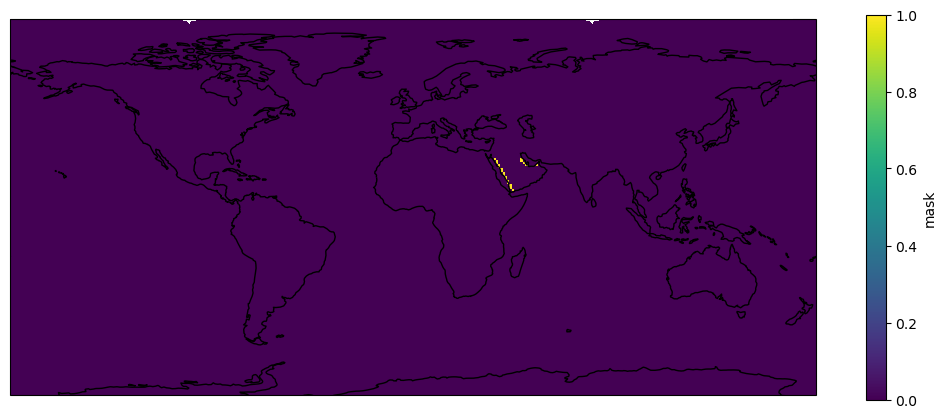

In [23]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Load grid and mask data
esm_grid_spec = xr.open_dataset(
    "/g/data/vk83/experiments/inputs/access-esm1p5/modern/share/ocean/grids/mosaic/global.1deg/2020.05.19/grid_spec.nc"
).compute()

om2_mask = xr.open_dataset(
    "/g/data/vk83/experiments/inputs/access-om2/ocean/grids/bathymetry/global.1deg/2020.10.22/ocean_mask.nc"
).compute()
om2_hgrid = xr.open_dataset(
    "/g/data/vk83/experiments/inputs/access-om2/ocean/grids/mosaic/global.1deg/2020.05.30/ocean_hgrid.nc"
).compute()

# Add/rename dims/coordinates consistently
esm_mask = esm_grid_spec[["wet", "y_T", "x_T"]]
esm_mask = esm_mask.rename({"wet": "mask", "y_T": "geolat_t", "x_T": "geolon_t"})
esm_mask = esm_mask.drop_vars(("grid_y_T", "grid_x_T"))
esm_mask = esm_mask.set_coords(("geolat_t", "geolon_t"))

om2_mask = om2_mask.rename({"ny": "grid_y_T", "nx": "grid_x_T"})
om2_mask = om2_mask.assign_coords({
    "geolat_t": (("grid_y_T", "grid_x_T"), om2_hgrid["y"].values[1:-1:2, 1:-1:2]),
    "geolon_t": (("grid_y_T", "grid_x_T"), om2_hgrid["x"].values[1:-1:2, 1:-1:2])
})

# Plot the difference in the masks
fig, ax = plt.subplots(figsize=(13,5), subplot_kw=dict(projection=ccrs.PlateCarree()))
(om2_mask - esm_mask)["mask"].plot(x="geolon_t", y="geolat_t")
ax.coastlines()

In [24]:
diff = (om2_mask - esm_mask)["mask"].assign_coords({
    "yaxis_1": (("grid_y_T"), range(1,301)),
    "xaxis_1": (("grid_x_T"), range(1,361))
}).swap_dims({"grid_y_T":"yaxis_1", "grid_x_T":  "xaxis_1"})

diff # location where cell is used in om2 but not in esm

<xarray.DataArray 'mask' (yaxis_1: 300, xaxis_1: 360)> Size: 864kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    geolat_t  (yaxis_1, xaxis_1) float64 864kB -77.88 -77.88 ... 65.63 65.21
    geolon_t  (yaxis_1, xaxis_1) float64 864kB -279.5 -278.5 ... 79.97 79.99
  * yaxis_1   (yaxis_1) int64 2kB 1 2 3 4 5 6 7 ... 294 295 296 297 298 299 300
  * xaxis_1   (xaxis_1) int64 3kB 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360

In [28]:
from scipy import ndimage

In [31]:
# start here
def fill_restart_copy_file(filename, newfilename):
    original_restart_dir = '/g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/'
    dest_restart_dir = '/g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/'

    ocean = xr.open_dataset(original_restart_dir + filename)
    print('File open: ' + filename)
    # `ocean` is your Dataset with variables like temp, salt
    # `diff` is a 2D (yaxis_1, xaxis_1) mask where diff == 1 needs filling
    # We assume diff does not vary over time or depth
    
    filled_vars = {}
    
    for varname in ocean.data_vars:
        print(varname)
        da = ocean[varname]  # shape: (Time, zaxis_1, yaxis_1, xaxis_1)
        filled_data = da.values.copy()
    
        for t in range(filled_data.shape[0]):
            for z in range(filled_data.shape[1]):
                slice2d = filled_data[t, z, :, :]
    
                # Mask to be filled (same for all variables)
                fill_mask = diff.values == 1
    
                # Define valid data (non-NaN, non-zero)
                valid_mask = np.isfinite(slice2d) & (slice2d != 0)
    
                # Compute nearest-neighbor indices to valid points
                dist, inds = ndimage.distance_transform_edt(
                    ~valid_mask,
                    return_indices=True
                )
    
                # Fill only the masked area
                slice2d[fill_mask] = slice2d[tuple(inds[:, fill_mask])]
    
                # Save back
                filled_data[t, z, :, :] = slice2d
    
        # Re-wrap into xarray
        filled_vars[varname] = xr.DataArray(
            filled_data,
            coords=da.coords,
            dims=da.dims,
            attrs=da.attrs
        )
    
    # Combine filled variables into new Dataset
    filled_ocean = xr.Dataset(filled_vars, attrs=ocean.attrs)
    filled_ocean.to_netcdf(dest_restart_dir + newfilename)
    print('Filled restart saved here: '+ dest_restart_dir + newfilename)
    return

In [32]:
fill_restart_copy_file('ocean_temp_salt_bottominterp_salttest.nc', 'ocean_temp_salt_wetcellfilled.nc')

File open: ocean_temp_salt_bottominterp_salttest.nc
salt
temp
Filled restart saved here: /g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/ocean_temp_salt_wetcellfilled.nc


Filling in wet cells added more unrealistic salinity values, so we interpolate horizontally where OM2 masks its ocean. 

In [33]:
check = xr.open_dataset('/g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/ocean_temp_salt_wetcellfilled.nc')

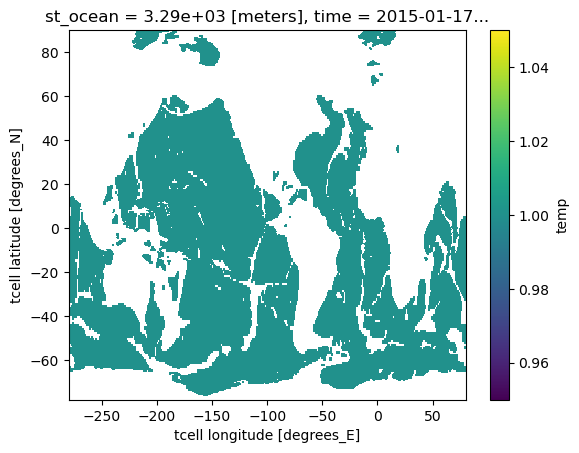

In [34]:
# get ocean mask from om2 output
sampledir = '/scratch/y99/dkh157/access-om2/archive/1deg_esm1p5_coldstart-cb9b96f8/output000/ocean/'
samplefile = sampledir + 'ocean-3d-temp-1-monthly-mean-ym_2015_01.nc'

ocean_mask = xr.open_dataset(samplefile)
ocean_mask = ocean_mask.temp.isel(time = 0)
ocean_mask = ocean_mask*0 + 1 
ocean_mask.isel(st_ocean = -10).plot()

In [35]:
ocean_mask = ocean_mask.rename({'xt_ocean':'xaxis_1', 'yt_ocean': 'yaxis_1','st_ocean':'zaxis_1'})\
    .assign_coords({'xaxis_1': bottom_interp_salt.xaxis_1,\
                'yaxis_1': bottom_interp_salt.yaxis_1,\
                'zaxis_1': bottom_interp_salt.zaxis_1})

In [51]:
## need to remove erroneous salt values. 
masked_salt = bottom_interp_salt.salt*ocean_mask

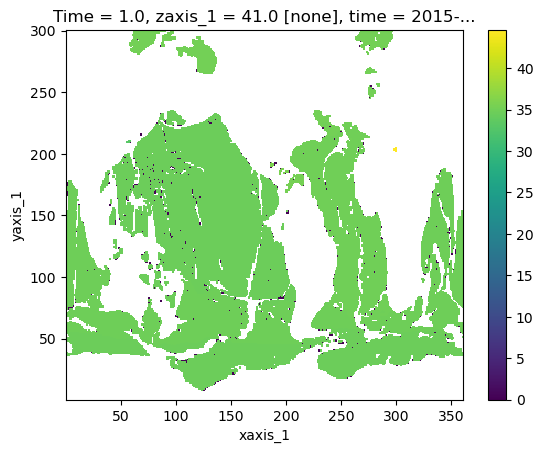

In [63]:
masked_salt.isel(zaxis_1 = -10).plot()

In [106]:

# Step 1: Mask out land points (keep only ocean data, NaN elsewhere, and only places where salt is valid i.e. greater than 0)
salt_masked = check.salt.where(ocean_mask == True).where(masked_salt >0)

# Step 2: Fill NaNs using nearest-neighbor interpolation in horizontal dims
Zi = salt_masked.interpolate_na(dim='xaxis_1', method="nearest", fill_value="extrapolate")\
    .interpolate_na(dim='yaxis_1', method="nearest", fill_value="extrapolate")

# Same for temperature - only need to fill empty ocean cells
temp_masked = check.temp.where(ocean_mask == True).where(masked_salt >0)
Zi_temp = temp_masked.interpolate_na(dim='xaxis_1', method="nearest", fill_value="extrapolate")\
    .interpolate_na(dim='yaxis_1', method="nearest", fill_value="extrapolate")

In [107]:
Zi = Zi*ocean_mask
Zi_temp = Zi_temp*ocean_mask

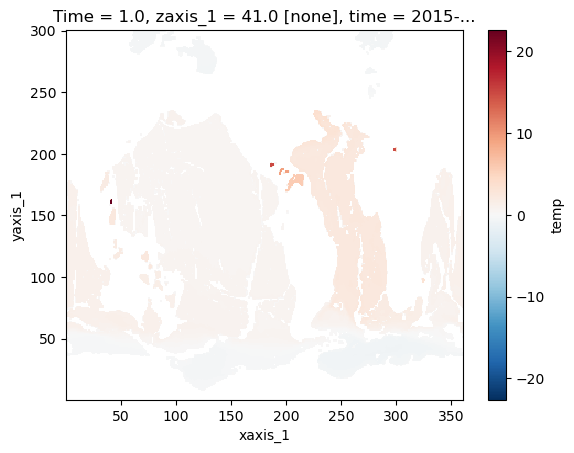

In [108]:
check.temp.where(ocean_mask == True).isel(zaxis_1 = -10).plot()

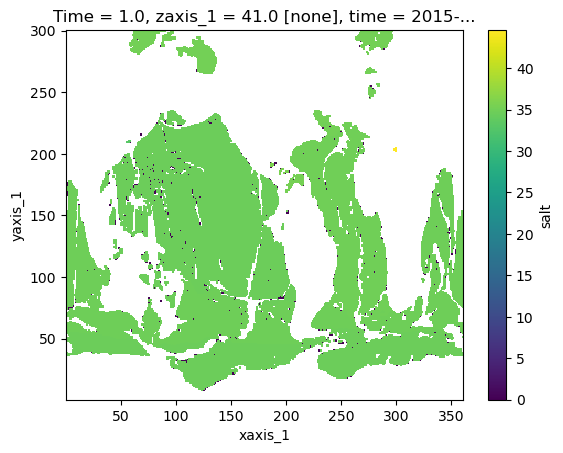

In [74]:
check.salt.where(ocean_mask == True).isel(zaxis_1 = -10).plot()

/jobfs/145805477.gadi-pbs/ipykernel_3031623/1816907133.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  post_fill_horz = xr.merge([Zi_temp.drop('time').to_dataset(name = 'temp'),Zi.drop('time').to_dataset(name = 'salt')])\


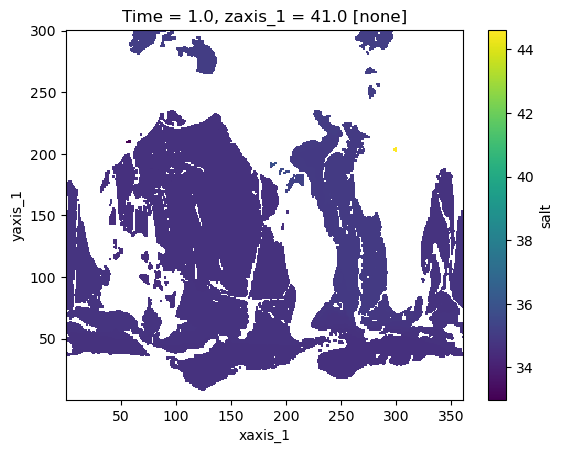

In [109]:
post_fill_horz = xr.merge([Zi_temp.drop('time').to_dataset(name = 'temp'),Zi.drop('time').to_dataset(name = 'salt')])\
    .transpose('Time','zaxis_1','yaxis_1','xaxis_1')
post_fill_horz.salt.isel(zaxis_1 = -10).plot()

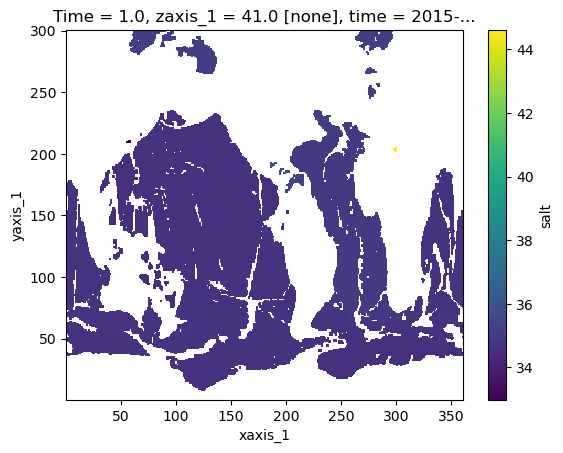

In [76]:
(post_fill_horz*ocean_mask).isel(zaxis_1 = -10).salt.plot()

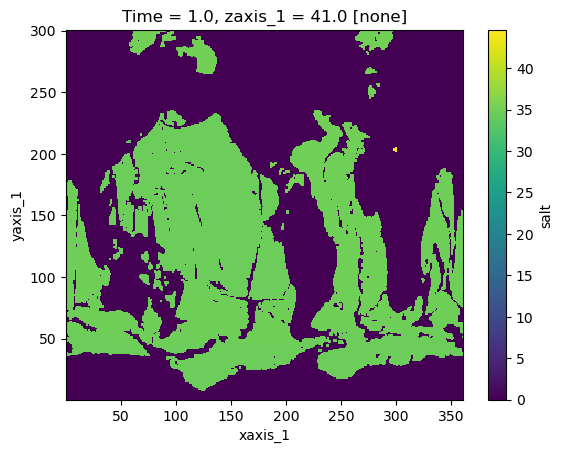

In [77]:
(post_fill_horz.fillna(0)).isel(zaxis_1 = -10).salt.plot()

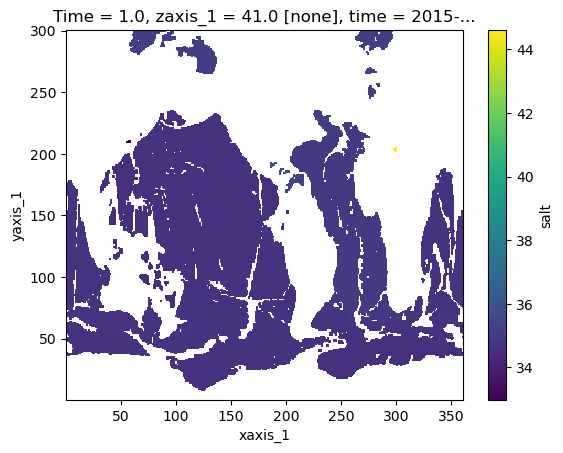

In [80]:
(post_fill_horz.fillna(0)*ocean_mask).isel(zaxis_1 = -10).salt.plot()

In [111]:
post_fill_horz.fillna(0).to_netcdf('/g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/ocean_temp_salt_post_fill_horz.nc')

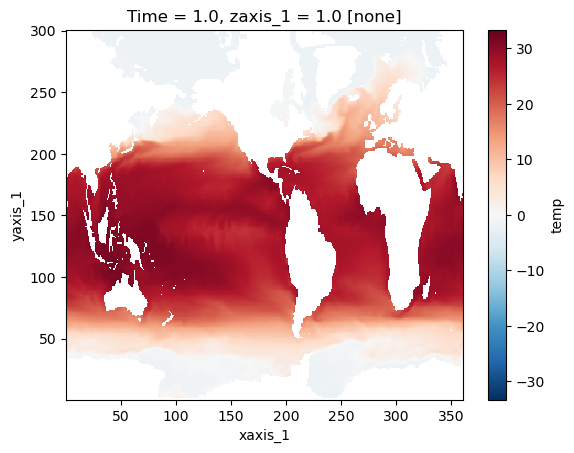

In [112]:
post_fill_horz.temp.isel(zaxis_1 = 0).plot()

In [113]:
check_filled = xr.open_dataset('/g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/ocean_temp_salt_post_fill_horz.nc')

In [90]:
xr.open_dataset('/g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/restart_om_vert/restart_filled_om2/ocean_temp_salt.res.nc')

<xarray.Dataset> Size: 86MB
Dimensions:  (Time: 1, zaxis_1: 50, yaxis_1: 300, xaxis_1: 360)
Coordinates:
  * Time     (Time) float64 8B 1.0
  * zaxis_1  (zaxis_1) float64 400B 1.0 2.0 3.0 4.0 5.0 ... 47.0 48.0 49.0 50.0
  * xaxis_1  (xaxis_1) float64 3kB 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
  * yaxis_1  (yaxis_1) float64 2kB 1.0 2.0 3.0 4.0 ... 297.0 298.0 299.0 300.0
Data variables:
    temp     (Time, zaxis_1, yaxis_1, xaxis_1) float64 43MB ...
    salt     (Time, zaxis_1, yaxis_1, xaxis_1) float64 43MB ...
Attributes:
    history:  Mon Jul 21 11:14:44 2025: ncatted -a cartesian_axis,xaxis_1,o,c...
    NCO:      netCDF Operators version 5.2.4 (Homepage = http://nco.sf.net, C...

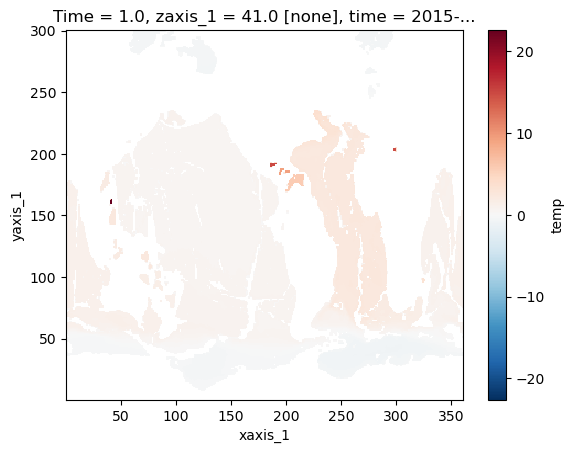

In [114]:
(check_filled.temp*ocean_mask).isel(zaxis_1 = -10).plot()

In [115]:
## need to save with file name ocean_temp_salt.res.nc and with cartesian coordinates in its attributes
check_filled.coords["xaxis_1"].attrs["cartesian_axis"] = "X"
check_filled.coords["yaxis_1"].attrs["cartesian_axis"] = "Y"
check_filled.coords["zaxis_1"].attrs["cartesian_axis"] = "Z"
check_filled.to_netcdf('/g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/ocean_temp_salt.res.nc')

In [104]:
check_filled

<xarray.Dataset> Size: 86MB
Dimensions:  (Time: 1, zaxis_1: 50, yaxis_1: 300, xaxis_1: 360)
Coordinates:
  * xaxis_1  (xaxis_1) float64 3kB 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
  * yaxis_1  (yaxis_1) float64 2kB 1.0 2.0 3.0 4.0 ... 297.0 298.0 299.0 300.0
  * Time     (Time) float64 8B 1.0
  * zaxis_1  (zaxis_1) float64 400B 1.0 2.0 3.0 4.0 5.0 ... 47.0 48.0 49.0 50.0
Data variables:
    temp     (Time, zaxis_1, yaxis_1, xaxis_1) float64 43MB ...
    salt     (Time, zaxis_1, yaxis_1, xaxis_1) float64 43MB ...

In [ ]:
##END

(-30.0, 250.0)

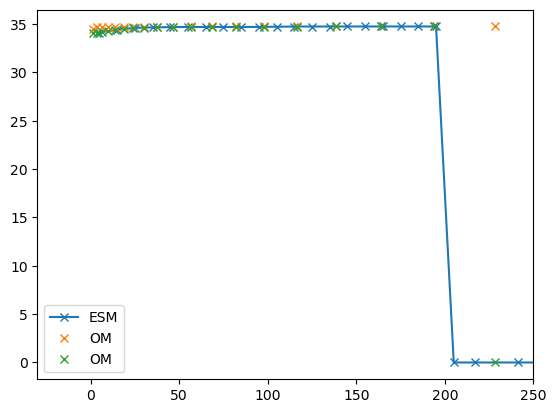

In [129]:
plt.plot(thkcello_esm.lev.values,\
         np.squeeze(ocean_file.salt.isel(xaxis_1 = 83, yaxis_1 = 11)), marker = 'x', label = 'ESM')
interp = np.interp(om2_thickness.st_ocean,thkcello_esm.lev.values, \
                     np.squeeze(ocean_file.salt.isel(xaxis_1 = 83, yaxis_1 = 11).values))
interp = custom_interp_with_zero_check(
                     np.squeeze(ocean_file.salt.isel(xaxis_1 = 83, yaxis_1 = 11).values),\
    om2_thickness.st_ocean,thkcello_esm.lev.values)
plt.plot(om2_thickness.st_ocean,interp, 'x', label = 'OM')

plt.plot(om2_thickness.st_ocean, np.squeeze(bottom_interp.where(mask_depth == True).salt.isel(xaxis_1 = 83, yaxis_1 = 11)), 'x', label = 'OM')

plt.legend()
plt.xlim([-30,250])

(-30.0, 1000.0)

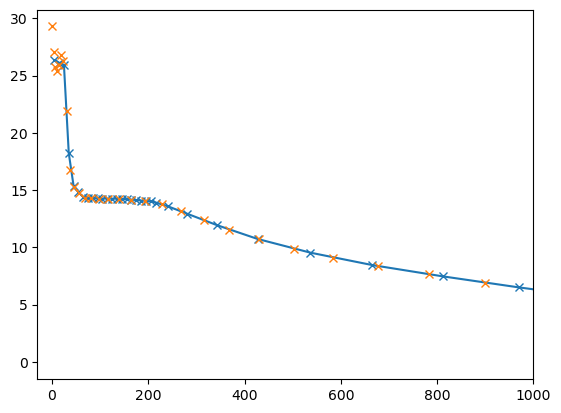

In [130]:
plt.plot(thkcello_esm.lev.values,\
         np.squeeze(ocean_file.temp.isel(xaxis_1 = 200, yaxis_1 = 100)), marker = 'x')
interp = CubicSpline(thkcello_esm.lev.values, \
                     np.squeeze(ocean_file.temp.isel(xaxis_1 = 200, yaxis_1 = 100).values))
plt.plot(om2_thickness.st_ocean,interp(om2_thickness.st_ocean), 'x')
plt.xlim([-30,1000])

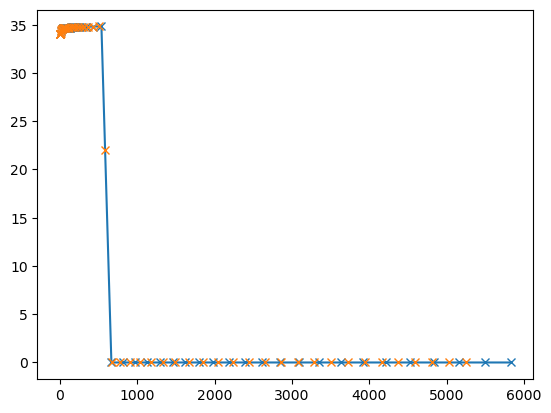

In [30]:
plt.plot(thkcello_esm.lev.values,\
         np.squeeze(ocean_file.salt.isel(xaxis_1 = 84, yaxis_1 = 11)), marker = 'x')
zero_check = np.interp(om2_thickness.st_ocean,thkcello_esm.lev.values, \
                     np.squeeze(ocean_file.salt.isel(xaxis_1 = 84, yaxis_1 =11).values ))
plt.plot(om2_thickness.st_ocean,zero_check, 'x')


(-30.0, 1000.0)

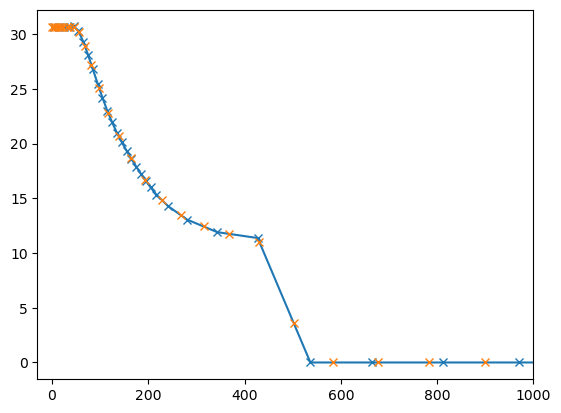

In [100]:
plt.plot(thkcello_esm.lev.values,\
         np.squeeze(ocean_file.temp.isel(xaxis_1 = 100, yaxis_1 = 100)), marker = 'x')
interp = np.interp(om2_thickness.st_ocean,thkcello_esm.lev.values, \
                     np.squeeze(ocean_file.temp.isel(xaxis_1 = 100, yaxis_1 = 100).values))
plt.plot(om2_thickness.st_ocean,interp, 'x')
plt.xlim([-30,1000])

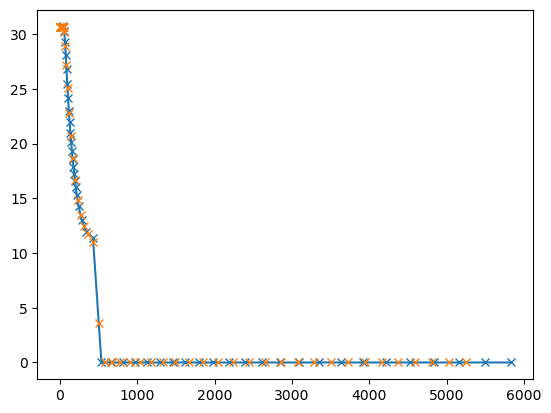

In [103]:
plt.plot(thkcello_esm.lev.values,\
         np.squeeze(ocean_file.temp.isel(xaxis_1 = 100, yaxis_1 = 100)), marker = 'x')
interp = np.interp(om2_thickness.st_ocean,thkcello_esm.lev.values, \
                     np.squeeze(ocean_file.temp.isel(xaxis_1 = 100, yaxis_1 = 100).values))
plt.plot(om2_thickness.st_ocean,interp, 'x')
#plt.xlim([-30,1000])

In [80]:
ocean_file.temp.isel(xaxis_1 = 100, yaxis_1 = 100).values

array([[30.64204661, 30.64530877, 30.64580881, 30.64926704, 30.69365782,
        30.2901732 , 29.31915472, 28.10582363, 26.79287613, 25.46443971,
        24.18167076, 22.99678922, 21.93266876, 20.98571288, 20.13000487,
        19.34210802, 18.6022987 , 17.8976841 , 17.22549496, 16.59083513,
        15.99427991, 15.33740581, 14.27771768, 13.05151344, 11.90540764,
        11.36826951,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [43]:
diff

<xarray.DataArray 'mask' (yaxis_1: 300, xaxis_1: 360)> Size: 864kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    geolat_t  (yaxis_1, xaxis_1) float64 864kB -77.88 -77.88 ... 65.63 65.21
    geolon_t  (yaxis_1, xaxis_1) float64 864kB -279.5 -278.5 ... 79.97 79.99
  * yaxis_1   (yaxis_1) int64 2kB 1 2 3 4 5 6 7 ... 294 295 296 297 298 299 300
  * xaxis_1   (xaxis_1) int64 3kB 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360

In [62]:
from scipy import ndimage

In [63]:
# start here
def fill_restart_copy_file(filename):
    #original_restart_dir = '/g/data/if69/qo9901/ocean_restart_frm_ESM_vk83/restart/ocean/'
    original_restart_dir = '/g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/restart_om_vert/'

    #original_restart_dir = ''
    #dest_restart_dir = '/g/data/if69/qo9901/ocean_restart_frm_ESM_vk83/restart_filled_om2/ocean/'
    dest_restart_dir = '/g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/restart_om_vert/restart_filled_om2/'

    ocean = xr.open_dataset(original_restart_dir + filename)
    print('File open: ' + filename)
    # `ocean` is your Dataset with variables like temp, salt
    # `diff` is a 2D (yaxis_1, xaxis_1) mask where diff == 1 needs filling
    # We assume diff does not vary over time or depth
    
    filled_vars = {}
    
    for varname in ocean.data_vars:
        print(varname)
        da = ocean[varname]  # shape: (Time, zaxis_1, yaxis_1, xaxis_1)
        filled_data = da.values.copy()
    
        for t in range(filled_data.shape[0]):
            for z in range(filled_data.shape[1]):
                slice2d = filled_data[t, z, :, :]
    
                # Mask to be filled (same for all variables)
                fill_mask = diff.values == 1
    
                # Define valid data (non-NaN, non-zero)
                valid_mask = np.isfinite(slice2d) & (slice2d != 0)
    
                # Compute nearest-neighbor indices to valid points
                dist, inds = ndimage.distance_transform_edt(
                    ~valid_mask,
                    return_indices=True
                )
    
                # Fill only the masked area
                slice2d[fill_mask] = slice2d[tuple(inds[:, fill_mask])]
    
                # Save back
                filled_data[t, z, :, :] = slice2d
    
        # Re-wrap into xarray
        filled_vars[varname] = xr.DataArray(
            filled_data,
            coords=da.coords,
            dims=da.dims,
            attrs=da.attrs
        )
    
    # Combine filled variables into new Dataset
    filled_ocean = xr.Dataset(filled_vars, attrs=ocean.attrs)
    filled_ocean.to_netcdf(dest_restart_dir + filename)
    print('Filled restart saved here: '+ dest_restart_dir + filename)
    return

In [219]:
fill_restart_copy_file('ocean_temp_salt_var_interpsalt2.nc')

File open: ocean_temp_salt_var_interpsalt2.nc
salt
temp
Filled restart saved here: /g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/restart_om_vert/restart_filled_om2/ocean_temp_salt_var_interpsalt2.nc


In [166]:
fill_restart_copy_file('ocean_temp_salt_var_interp2.nc')

File open: ocean_temp_salt_var_interp2.nc
salt
temp
Filled restart saved here: /g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/restart_om_vert/restart_filled_om2/ocean_temp_salt_var_interp2.nc


In [100]:
#fill_restart_copy_file('ocean_temp_salt_corrected_topo.res.nc')

temp
salt
Filled restart saved here: /g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/restart_om_vert/restart_filled_om2/ocean_temp_salt_corrected_topo.res.nc


In [226]:
check= xr.open_dataset('/g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/restart_om_vert/restart_filled_om2/ocean_temp_salt_var_interpsalt2.nc')

In [231]:
check.assign_coords({'zaxis_1':check.zaxis_1.astype('float64')}).to_netcdf('/g/data/if69/qo9901/SSP-585-10-re1-ocn-restart-2014/restart_om_vert/restart_filled_om2/ocean_temp_salt.res.nc')

In [232]:
check.salt.any()<0

<xarray.DataArray 'salt' ()> Size: 1B
array(False)

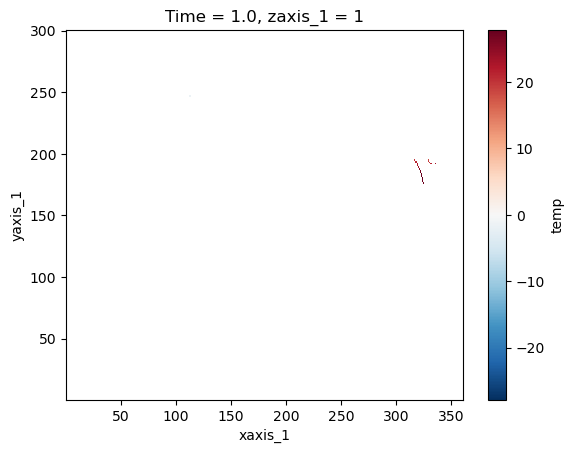

In [221]:
check.where(diff).isel(zaxis_1 =0).temp.plot()

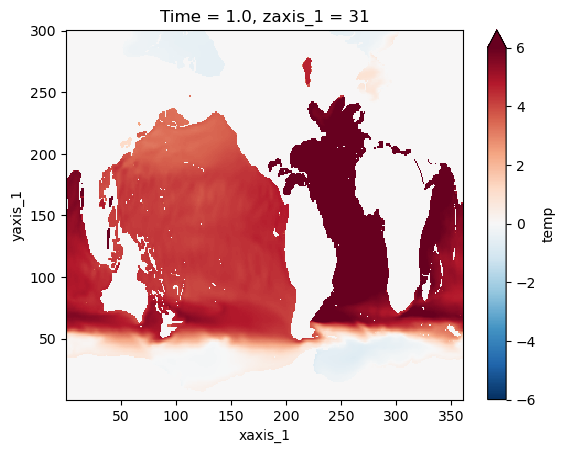

In [225]:
check.isel(zaxis_1 =30).temp.plot(vmin = -6)